In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from sklearn.model_selection import train_test_split

import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# from mlxtend.plotting import plot_confusion_matrix

In [3]:
data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1",engine='python',names=['label', 'time', 'date', 'query', 'username', 'text'])

In [4]:
data.head()

,label,time,date,query,username,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
data = data[['text','label']]

In [6]:
data.head()

,text,label
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [7]:
data.shape

(1600000, 2)

In [8]:
data.label.value_counts()

label
0    800000
4    800000
Name: count, dtype: int64

In [9]:
data.isnull().sum()

text     0
label    0
dtype: int64

In [10]:
data.label = data.label.apply(lambda x : 1 if x == 4 else x )

In [11]:
data.label.value_counts()

label
0    800000
1    800000
Name: count, dtype: int64

In [12]:
data_pos = data[data['label']==1]
data_neg = data[data['label']==0]

In [13]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [14]:
data = pd.concat([data_pos, data_neg])

In [15]:
data['text']=data['text'].str.lower()

In [16]:
data['text'].tail()

19995    not much time off this weekend, work trip to m...
19996                            one more day of holidays 
19997    feeling so down right now .. i hate you damn h...
19998    geez,i hv to read the whole book of personalit...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

In [17]:
stopwords_list = stopwords.words('english')

In [18]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [19]:
STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [20]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [21]:
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'].tail()

19995    much time weekend work trip malmï¿½ frisat tod...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999     threw sign donnie bent get thingee made sad face
Name: text, dtype: object

In [22]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [23]:
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
data['text'].tail()

19995    much time wekend work trip malmï¿½ frisat toda...
19996                                     one day holidays
19997                       feling right hate damn humprey
19998    gezi hv read whole bok personality types embar...
19999       threw sign donie bent get thinge made sad face
Name: text, dtype: object

In [24]:
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)

In [25]:
data['text']= data['text'].apply(lambda x: cleaning_email(x))
data['text'].tail()

19995    much time wekend work trip malmï¿½ frisat toda...
19996                                     one day holidays
19997                       feling right hate damn humprey
19998    gezi hv read whole bok personality types embar...
19999       threw sign donie bent get thinge made sad face
Name: text, dtype: object

In [26]:
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

In [27]:
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
data['text'].tail()

19995    much time wekend work trip malmï¿½ frisat toda...
19996                                     one day holidays
19997                       feling right hate damn humprey
19998    gezi hv read whole bok personality types embar...
19999       threw sign donie bent get thinge made sad face
Name: text, dtype: object

In [28]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

In [29]:
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text'].tail()

19995    much time wekend work trip malmï¿½ frisat toda...
19996                                     one day holidays
19997                       feling right hate damn humprey
19998    gezi hv read whole bok personality types embar...
19999       threw sign donie bent get thinge made sad face
Name: text, dtype: object

In [30]:
tokenizer = RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(tokenizer.tokenize)

In [31]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

data['text']= data['text'].apply(lambda x: stemming_on_text(x))

In [32]:
# lm = nltk.WordNetLemmatizer()
# def lemmatizer_on_text(data):
#     text = [lm.lemmatize(word) for word in data]
#     return data

# data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))

In [33]:
X=data.text
y=data.label

In [34]:
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [35]:
sequences_matrix.shape

(40000, 500)

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

In [37]:
def tensorflow_based_model(name='inputs',shape=[max_len]):
    inputs = Input(name='inputs',shape=max_len)# Step1 
    layer = Embedding(2000,50,input_length=max_len)(inputs)# Step2 
    layer = LSTM(64)(layer) # Step3 
    layer = Dense(256,name='FC1')(layer) #step4
    layer = Activation('relu')(layer) #step5
    layer = Dropout(0.5)(layer) #step6
    layer = Dense(1,name='output_layer')(layer) #step7
    layer = Activation('sigmoid')(layer) #step8
    model = Model(inputs=inputs,outputs=layer)
    
    return model 

In [38]:
model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])  

In [40]:
history=model.fit(X_train,Y_train,batch_size=80,epochs=1, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')

315/315 [==============================] - 169s 537ms/step - loss: 0.5155 - accuracy: 0.7498 - val_loss: 0.5214 - val_accuracy: 0.7407
Training finished !!


In [41]:
accr1 = model.evaluate(X_test,Y_test) #we are starting to test the model here

375/375 [==============================] - 22s 56ms/step - loss: 0.5196 - accuracy: 0.7439


In [42]:
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1])) #the accuracy of the model on test data is given below

Test set
  Accuracy: 0.74


In [43]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5) 

375/375 [==============================] - 20s 52ms/step


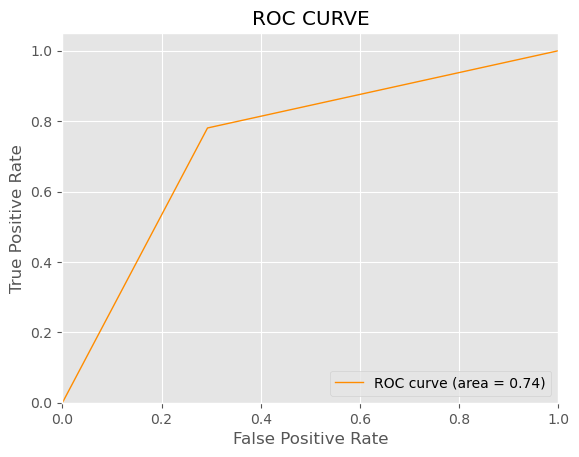

In [44]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()